In [4]:
INPUT_WIDTH = 640
INPUT_HEIGHT = 640
SCORE_THRESHOLD = 0.5
NMS_THRESHOLD = 0.45
CONFIDENCE_THRESHOLD = 0.45
 
# Text parameters.
FONT_FACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1
 
# Colors.
BLACK  = (0,0,0)
BLUE   = (255,178,50)
YELLOW = (0,255,255)

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def draw_label(im, label, x, y):
    """Draw text onto image at location."""
    # Get text size.
    text_size = cv2.getTextSize(label, FONT_FACE, FONT_SCALE, THICKNESS)
    dim, baseline = text_size[0], text_size[1]
    # Use text size to create a BLACK rectangle.
    cv2.rectangle(im, (x,y), (x + dim[0], y + dim[1] + baseline), (0,0,0), cv2.FILLED);
    # Display text inside the rectangle.
    cv2.putText(im, label, (x, y + dim[1]), FONT_FACE, FONT_SCALE, YELLOW, THICKNESS, cv2.LINE_AA)


In [6]:
def pre_process(input_image, net):
      # Create a 4D blob from a frame.
      blob = cv2.dnn.blobFromImage(input_image, 1/255,  (INPUT_WIDTH, INPUT_HEIGHT), [0,0,0], 1, crop=False)
 
      # Sets the input to the network.
      net.setInput(blob)
 
      # Run the forward pass to get output of the output layers.
      outputs = net.forward(net.getUnconnectedOutLayersNames())
      return outputs

In [31]:
def post_process(input_image, outputs):
      classes = ['area']
      # Lists to hold respective values while unwrapping.
      class_ids = []
      confidences = []
      boxes = []
      # Rows.
      rows = outputs[0].shape[1]
      image_height, image_width = input_image.shape[:2]
      # Resizing factor.
      x_factor = image_width / INPUT_WIDTH
      y_factor =  image_height / INPUT_HEIGHT
      # Iterate through detections.
      for r in range(rows):
            row = outputs[0][0][r]
            confidence = row[4]
            # Discard bad detections and continue.
            if confidence >= CONFIDENCE_THRESHOLD:
                  classes_scores = row[5:]
                  # Get the index of max class score.
                  class_id = np.argmax(classes_scores)
                  #  Continue if the class score is above threshold.
                  if (classes_scores[class_id] > SCORE_THRESHOLD):
                        confidences.append(confidence)
                        class_ids.append(class_id)
                        cx, cy, w, h = row[0], row[1], row[2], row[3]
                        left = int((cx - w/2) * x_factor)
                        top = int((cy - h/2) * y_factor)
                        width = int(w * x_factor)
                        height = int(h * y_factor)
                        
                        box = np.array([left, top, width, height])
                        boxes.append(box)
      indices = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD, NMS_THRESHOLD)
      for i in indices:
            box = boxes[i]
            left = box[0]
            top = box[1]
            width = box[2]
            height = box[3]             
            # Draw bounding box.             
            input_image = cv2.rectangle(input_image, (left, top), (left+width, top+height), (255,0,0), 2)
            # Class label.                      
              
            # Draw label.             
            
      return input_image
  

Inference time: 374.68 ms


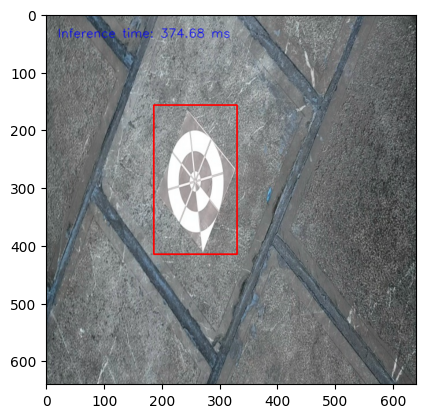

In [32]:

      classes = ['area']
      # Load image.
      frame = cv2.imread("data_train/images/train/img_train_258.jpg")
      # Give the weight files to the model and load the network using       them.
      modelWeights = "best_13mb.onnx"
      net = cv2.dnn.readNet(modelWeights)
      # Process image.
      detections = pre_process(frame, net)
      img = post_process(frame.copy(), detections)
      """
      Put efficiency information. The function getPerfProfile returns       the overall time for inference(t) 
      and the timings for each of the layers(in layersTimes).
      """
      t, _ = net.getPerfProfile()
      label = 'Inference time: %.2f ms' % (t * 1000.0 /  cv2.getTickFrequency())
      print(label)
      cv2.putText(img, label, (20, 40), FONT_FACE, FONT_SCALE,  (0, 0, 255), THICKNESS, cv2.LINE_AA)
      plt.imshow(img)